# Action1	

"PM2.5数据集
https://archive.ics.uci.edu/ml/datasets/Beijing%20PM2.5%20Data

预测未来北京PM2.5的值"		

"1、使用时间序列工具（ARMA或者LTSM）（40points）

2、结果正确（20points）

3、代码进行注释，写明解决方案思路（20points)"

In [8]:
import pandas as pd

dataset = pd.read_csv('./pollution.csv', index_col=0)
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [11]:
values = dataset.values
values

array([[129.0, -16, -4.0, ..., 1.79, 0, 0],
       [148.0, -15, -4.0, ..., 2.68, 0, 0],
       [159.0, -11, -5.0, ..., 3.57, 0, 0],
       ...,
       [10.0, -22, -3.0, ..., 242.7, 0, 0],
       [8.0, -22, -4.0, ..., 246.72, 0, 0],
       [12.0, -21, -3.0, ..., 249.85, 0, 0]], dtype=object)

In [3]:
import matplotlib.pyplot as plt

groups = [0,1,2,3,4,5,6,7]
i = 1
for group in range(8):
    plt.subplot(8,1,i)
    plt.plot(values[:,group])
    plt.title(dataset.columns[group])
    i = i+1
plt.show()

<Figure size 640x480 with 8 Axes>

In [4]:
dataset['wnd_dir'].value_counts()

SE    15290
NW    14130
cv     9384
NE     4996
Name: wnd_dir, dtype: int64

In [13]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
values = values.astype('float32')
values

array([[129.  , -16.  ,  -4.  , ...,   1.79,   0.  ,   0.  ],
       [148.  , -15.  ,  -4.  , ...,   2.68,   0.  ,   0.  ],
       [159.  , -11.  ,  -5.  , ...,   3.57,   0.  ,   0.  ],
       ...,
       [ 10.  , -22.  ,  -3.  , ..., 242.7 ,   0.  ,   0.  ],
       [  8.  , -22.  ,  -4.  , ..., 246.72,   0.  ,   0.  ],
       [ 12.  , -21.  ,  -3.  , ..., 249.85,   0.  ,   0.  ]],
      dtype=float32)

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)
scaled.shape

(43800, 8)

In [22]:
# 将时间序列数据转换为适用于监督学习的数据
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # 预测序列 (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # 去掉NaN行
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [23]:
reframed = series_to_supervised(scaled, 1, 1)
reframed.to_csv('reframed-1.csv')
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0


In [33]:
values = reframed.values
#split:
#LSTM can not train test split
#XGBoost can, independent
n_train_hours = int(len(values)*0.8)
train = values[:n_train_hours,:]
test = values[n_train_hours:,:]
train_X, train_y = train[:,:-1], train[:,-1]
test_X, test_y = test[:,:-1], test[:,-1]
train_X.shape, train_y.shape


((35039, 15), (35039,))

In [34]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [35]:
train_X.shape,test_X.shape, train_y.shape, test_y.shape

((35039, 1, 15), (8760, 1, 15), (35039,), (8760,))

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

#fit model
model=Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

result = model.fit(train_X, train_y, epochs=10, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 35039 samples, validate on 8760 samples
Epoch 1/10
35039/35039 - 3s - loss: 0.0015 - val_loss: 5.5854e-04
Epoch 2/10
35039/35039 - 1s - loss: 8.2736e-04 - val_loss: 3.2975e-04
Epoch 3/10
35039/35039 - 1s - loss: 4.2665e-04 - val_loss: 2.1487e-04
Epoch 4/10
35039/35039 - 1s - loss: 3.4427e-04 - val_loss: 2.2375e-04
Epoch 5/10
35039/35039 - 1s - loss: 3.3577e-04 - val_loss: 2.3179e-04
Epoch 6/10
35039/35039 - 1s - loss: 3.3937e-04 - val_loss: 2.2772e-04
Epoch 7/10
35039/35039 - 1s - loss: 3.3986e-04 - val_loss: 2.1939e-04
Epoch 8/10
35039/35039 - 1s - loss: 3.3931e-04 - val_loss: 2.1654e-04
Epoch 9/10
35039/35039 - 1s - loss: 3.3880e-04 - val_loss: 2.1583e-04
Epoch 10/10
35039/35039 - 1s - loss: 3.3854e-04 - val_loss: 2.1596e-04


In [37]:
#model prediction
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

test_predict

array([[0.00081986],
       [0.000289  ],
       [0.00066698],
       ...,
       [0.00104748],
       [0.00146453],
       [0.00040097]], dtype=float32)

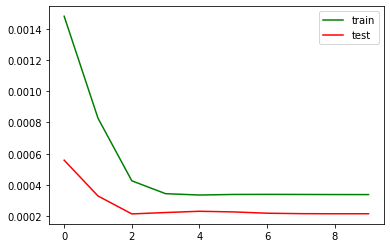

In [41]:
# plot loss
line1 = result.history['loss']
line2 = result.history['val_loss']
plt.plot(line1, label='train', c='g')
plt.plot(line2, label='test', c='r')
plt.legend(loc='best')

In [42]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50)                13200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 13,251
Trainable params: 13,251
Non-trainable params: 0
_________________________________________________________________
